## 1. Import Libraries and Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert DATE to datetime and set as index with Business Day frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')

print(f"✓ Dataset loaded: {len(df)} observations from {df.index.min()} to {df.index.max()}")
print(f"✓ Business Day frequency configured")

✓ Dataset loaded: 10616 observations from 1985-01-02 00:00:00 to 2025-09-10 00:00:00
✓ Business Day frequency configured


## 2. Feature Engineering: Calculate Key Variables

In [3]:
# Calculate log returns for gold and silver
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df['SILVER_LOG_RETURN'] = np.log(df['SILVER_PRICE']) - np.log(df['SILVER_PRICE'].shift(1))

# Calculate daily variation in Geopolitical Risk (GPRD_DELTA)
df['GPRD_DELTA'] = df['GPRD'].diff()
df['GPRD_ACT_DELTA'] = df['GPRD_ACT'].diff()
df['GPRD_THREAT_DELTA'] = df['GPRD_THREAT'].diff()

# Fill first observation with 0 (as requested)
df['GPRD_DELTA'].fillna(0, inplace=True)
df['GPRD_ACT_DELTA'].fillna(0, inplace=True)
df['GPRD_THREAT_DELTA'].fillna(0, inplace=True)

# Create lagged variables for predictive analysis
df['GPRD_DELTA_LAG1'] = df['GPRD_DELTA'].shift(1)
df['GPRD_ACT_DELTA_LAG1'] = df['GPRD_ACT_DELTA'].shift(1)
df['GPRD_THREAT_DELTA_LAG1'] = df['GPRD_THREAT_DELTA'].shift(1)

print("\n✓ Feature engineering completed:")
print("  - Log returns calculated")
print("  - GPRD daily variations (DELTA) calculated")
print("  - Lagged variables created for predictive analysis")

# Display summary
print("\nNew Features Summary:")
df[['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN', 'GPRD_DELTA', 'GPRD_ACT_DELTA', 'GPRD_THREAT_DELTA']].describe().round(6)


✓ Feature engineering completed:
  - Log returns calculated
  - GPRD daily variations (DELTA) calculated
  - Lagged variables created for predictive analysis

New Features Summary:


,GOLD_LOG_RETURN,SILVER_LOG_RETURN,GPRD_DELTA,GPRD_ACT_DELTA,GPRD_THREAT_DELTA
count,10525.000000,10511.000000,10616.000000,10616.000000,10616.000000
mean,0.000230,0.000189,-0.031605,-0.050219,-0.009985
std,0.009755,0.017441,39.684788,55.916398,51.308448
min,-0.088756,-0.229874,-245.930000,-555.630000,-395.020000
25%,-0.004307,-0.007518,-23.062500,-30.805000,-29.460000
50%,0.000138,0.000000,-0.180000,-0.215000,-0.020000
75%,0.005005,0.008724,22.522500,29.972500,29.192500
max,0.104371,0.138642,571.440000,1100.960000,324.550000


In [4]:
# Remove observations with missing data for complete analysis
df_complete = df.dropna(subset=['GOLD_LOG_RETURN', 'GPRD_DELTA', 'GPRD_DELTA_LAG1']).copy()

print(f"✓ Complete dataset: {len(df_complete)} observations (removed {len(df) - len(df_complete)} NaN rows)")
print(f"  Analysis period: {df_complete.index.min()} to {df_complete.index.max()}")

✓ Complete dataset: 10525 observations (removed 91 NaN rows)
  Analysis period: 1985-01-03 00:00:00 to 2025-09-10 00:00:00


## 3. Exploratory Analysis: Geopolitical Risk Shocks

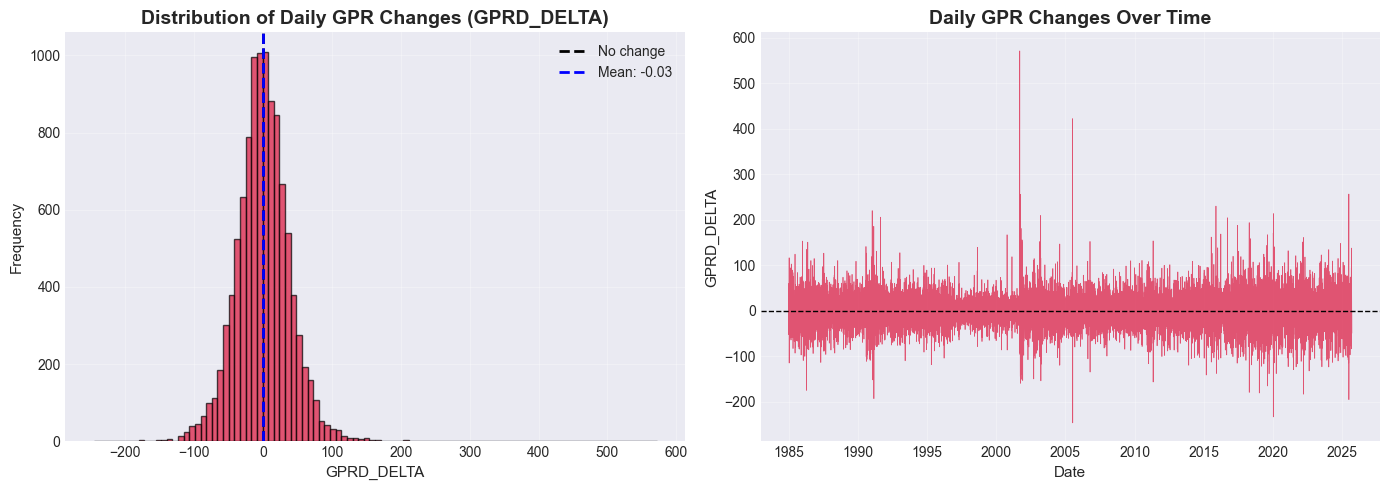


GPRD_DELTA Statistics:
  Mean: -0.0319
  Std Dev: 39.8560
  Min: -245.9300
  Max: 571.4400
  Skewness: 0.5135
  Kurtosis: 7.2917


In [5]:
# Distribution of GPRD_DELTA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_complete['GPRD_DELTA'], bins=100, color='crimson', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='No change')
axes[0].axvline(x=df_complete['GPRD_DELTA'].mean(), color='blue', linestyle='--', linewidth=2, 
                label=f"Mean: {df_complete['GPRD_DELTA'].mean():.2f}")
axes[0].set_title('Distribution of Daily GPR Changes (GPRD_DELTA)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('GPRD_DELTA', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series
axes[1].plot(df_complete.index, df_complete['GPRD_DELTA'], color='crimson', linewidth=0.5, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Daily GPR Changes Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('GPRD_DELTA', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGPRD_DELTA Statistics:")
print(f"  Mean: {df_complete['GPRD_DELTA'].mean():.4f}")
print(f"  Std Dev: {df_complete['GPRD_DELTA'].std():.4f}")
print(f"  Min: {df_complete['GPRD_DELTA'].min():.4f}")
print(f"  Max: {df_complete['GPRD_DELTA'].max():.4f}")
print(f"  Skewness: {df_complete['GPRD_DELTA'].skew():.4f}")
print(f"  Kurtosis: {df_complete['GPRD_DELTA'].kurtosis():.4f}")

## 4. Contemporaneous Correlation Analysis

**Test**: Do gold/silver returns increase on days when geopolitical risk increases?

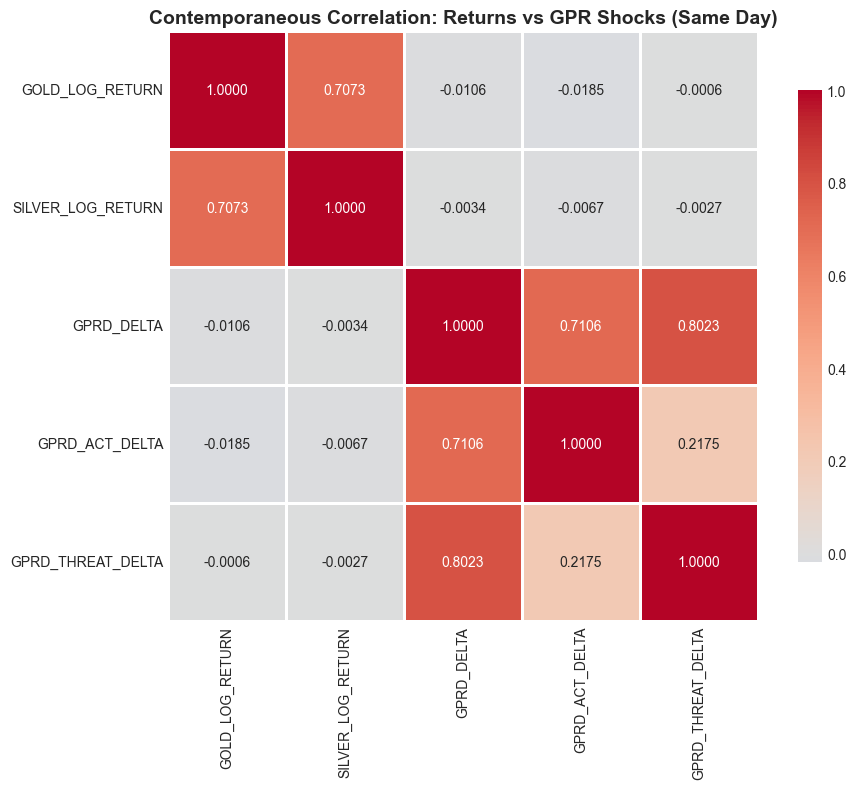


Key Contemporaneous Correlations:
  Gold Return - GPRD_DELTA:        -0.010615
  Gold Return - GPRD_ACT_DELTA:    -0.018548
  Gold Return - GPRD_THREAT_DELTA: -0.000596

  Silver Return - GPRD_DELTA:        -0.003426
  Silver Return - GPRD_ACT_DELTA:    -0.006663
  Silver Return - GPRD_THREAT_DELTA: -0.002718


In [6]:
# Correlation matrix: returns vs GPRD_DELTA (same day)
corr_vars = ['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN', 'GPRD_DELTA', 'GPRD_ACT_DELTA', 'GPRD_THREAT_DELTA']
corr_matrix_contemp = df_complete[corr_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_contemp, annot=True, fmt='.4f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Contemporaneous Correlation: Returns vs GPR Shocks (Same Day)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Contemporaneous Correlations:")
print(f"  Gold Return - GPRD_DELTA:        {corr_matrix_contemp.loc['GOLD_LOG_RETURN', 'GPRD_DELTA']:.6f}")
print(f"  Gold Return - GPRD_ACT_DELTA:    {corr_matrix_contemp.loc['GOLD_LOG_RETURN', 'GPRD_ACT_DELTA']:.6f}")
print(f"  Gold Return - GPRD_THREAT_DELTA: {corr_matrix_contemp.loc['GOLD_LOG_RETURN', 'GPRD_THREAT_DELTA']:.6f}")
print(f"\n  Silver Return - GPRD_DELTA:        {corr_matrix_contemp.loc['SILVER_LOG_RETURN', 'GPRD_DELTA']:.6f}")
print(f"  Silver Return - GPRD_ACT_DELTA:    {corr_matrix_contemp.loc['SILVER_LOG_RETURN', 'GPRD_ACT_DELTA']:.6f}")
print(f"  Silver Return - GPRD_THREAT_DELTA: {corr_matrix_contemp.loc['SILVER_LOG_RETURN', 'GPRD_THREAT_DELTA']:.6f}")

In [7]:
# Statistical significance test (Pearson correlation)
def correlation_significance(x, y, name_x, name_y):
    """
    Test statistical significance of correlation
    H0: correlation = 0
    H1: correlation ≠ 0
    """
    # Remove NaN pairs
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    corr, pval = stats.pearsonr(x_clean, y_clean)
    
    print(f"\n{name_x} vs {name_y}:")
    print(f"  Correlation: {corr:.6f}")
    print(f"  p-value: {pval:.6f}")
    if pval < 0.001:
        print(f"  ✓ Highly significant (p < 0.001)***")
    elif pval < 0.01:
        print(f"  ✓ Significant (p < 0.01)**")
    elif pval < 0.05:
        print(f"  ✓ Significant (p < 0.05)*")
    else:
        print(f"  ✗ Not significant (p ≥ 0.05)")
    
    return corr, pval

print("="*70)
print("CONTEMPORANEOUS CORRELATION SIGNIFICANCE TESTS")
print("="*70)

# Gold tests
correlation_significance(df_complete['GOLD_LOG_RETURN'].values, 
                        df_complete['GPRD_DELTA'].values,
                        'Gold Return', 'GPRD_DELTA')

correlation_significance(df_complete['GOLD_LOG_RETURN'].values, 
                        df_complete['GPRD_THREAT_DELTA'].values,
                        'Gold Return', 'GPRD_THREAT_DELTA')

# Silver tests
correlation_significance(df_complete['SILVER_LOG_RETURN'].values, 
                        df_complete['GPRD_DELTA'].values,
                        'Silver Return', 'GPRD_DELTA')

correlation_significance(df_complete['SILVER_LOG_RETURN'].values, 
                        df_complete['GPRD_THREAT_DELTA'].values,
                        'Silver Return', 'GPRD_THREAT_DELTA')

CONTEMPORANEOUS CORRELATION SIGNIFICANCE TESTS

Gold Return vs GPRD_DELTA:
  Correlation: -0.010615
  p-value: 0.276199
  ✗ Not significant (p ≥ 0.05)

Gold Return vs GPRD_THREAT_DELTA:
  Correlation: -0.000596
  p-value: 0.951278
  ✗ Not significant (p ≥ 0.05)

Silver Return vs GPRD_DELTA:
  Correlation: -0.003426
  p-value: 0.725453
  ✗ Not significant (p ≥ 0.05)

Silver Return vs GPRD_THREAT_DELTA:
  Correlation: -0.002718
  p-value: 0.780509
  ✗ Not significant (p ≥ 0.05)


(-0.002718297685448406, 0.7805089389734662)

## 5. Lagged Correlation Analysis

**Test**: Do geopolitical risk shocks predict next-day precious metal returns?

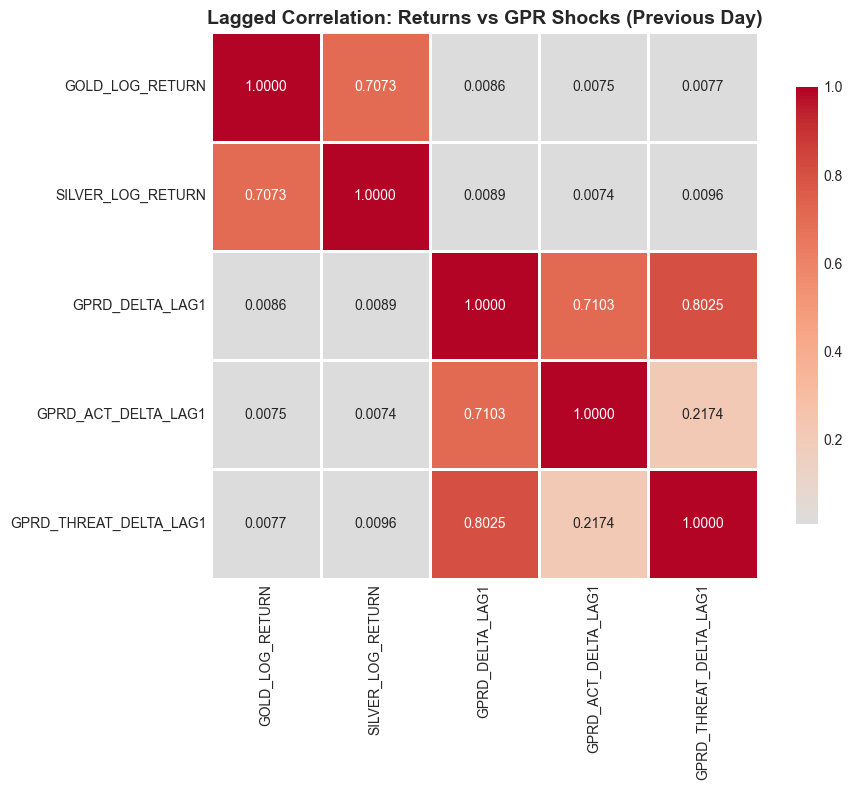


Key Lagged Correlations (Predictive):
  Gold Return - GPRD_DELTA_LAG1:        0.008646
  Gold Return - GPRD_ACT_DELTA_LAG1:    0.007474
  Gold Return - GPRD_THREAT_DELTA_LAG1: 0.007691

  Silver Return - GPRD_DELTA_LAG1:        0.008934
  Silver Return - GPRD_ACT_DELTA_LAG1:    0.007403
  Silver Return - GPRD_THREAT_DELTA_LAG1: 0.009628


In [8]:
# Correlation matrix: returns vs lagged GPRD_DELTA (previous day)
lagged_vars = ['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN', 'GPRD_DELTA_LAG1', 'GPRD_ACT_DELTA_LAG1', 'GPRD_THREAT_DELTA_LAG1']
corr_matrix_lagged = df_complete[lagged_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_lagged, annot=True, fmt='.4f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Lagged Correlation: Returns vs GPR Shocks (Previous Day)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Lagged Correlations (Predictive):")
print(f"  Gold Return - GPRD_DELTA_LAG1:        {corr_matrix_lagged.loc['GOLD_LOG_RETURN', 'GPRD_DELTA_LAG1']:.6f}")
print(f"  Gold Return - GPRD_ACT_DELTA_LAG1:    {corr_matrix_lagged.loc['GOLD_LOG_RETURN', 'GPRD_ACT_DELTA_LAG1']:.6f}")
print(f"  Gold Return - GPRD_THREAT_DELTA_LAG1: {corr_matrix_lagged.loc['GOLD_LOG_RETURN', 'GPRD_THREAT_DELTA_LAG1']:.6f}")
print(f"\n  Silver Return - GPRD_DELTA_LAG1:        {corr_matrix_lagged.loc['SILVER_LOG_RETURN', 'GPRD_DELTA_LAG1']:.6f}")
print(f"  Silver Return - GPRD_ACT_DELTA_LAG1:    {corr_matrix_lagged.loc['SILVER_LOG_RETURN', 'GPRD_ACT_DELTA_LAG1']:.6f}")
print(f"  Silver Return - GPRD_THREAT_DELTA_LAG1: {corr_matrix_lagged.loc['SILVER_LOG_RETURN', 'GPRD_THREAT_DELTA_LAG1']:.6f}")

In [9]:
# Statistical significance test for lagged correlations
print("="*70)
print("LAGGED CORRELATION SIGNIFICANCE TESTS (PREDICTIVE POWER)")
print("="*70)

# Gold tests
correlation_significance(df_complete['GOLD_LOG_RETURN'].values, 
                        df_complete['GPRD_DELTA_LAG1'].values,
                        'Gold Return (t)', 'GPRD_DELTA (t-1)')

correlation_significance(df_complete['GOLD_LOG_RETURN'].values, 
                        df_complete['GPRD_THREAT_DELTA_LAG1'].values,
                        'Gold Return (t)', 'GPRD_THREAT_DELTA (t-1)')

# Silver tests
correlation_significance(df_complete['SILVER_LOG_RETURN'].values, 
                        df_complete['GPRD_DELTA_LAG1'].values,
                        'Silver Return (t)', 'GPRD_DELTA (t-1)')

correlation_significance(df_complete['SILVER_LOG_RETURN'].values, 
                        df_complete['GPRD_THREAT_DELTA_LAG1'].values,
                        'Silver Return (t)', 'GPRD_THREAT_DELTA (t-1)')

LAGGED CORRELATION SIGNIFICANCE TESTS (PREDICTIVE POWER)

Gold Return (t) vs GPRD_DELTA (t-1):
  Correlation: 0.008646
  p-value: 0.375130
  ✗ Not significant (p ≥ 0.05)

Gold Return (t) vs GPRD_THREAT_DELTA (t-1):
  Correlation: 0.007691
  p-value: 0.430158
  ✗ Not significant (p ≥ 0.05)

Silver Return (t) vs GPRD_DELTA (t-1):
  Correlation: 0.008934
  p-value: 0.359747
  ✗ Not significant (p ≥ 0.05)

Silver Return (t) vs GPRD_THREAT_DELTA (t-1):
  Correlation: 0.009628
  p-value: 0.323632
  ✗ Not significant (p ≥ 0.05)


(0.00962822374889124, 0.32363210828564254)

## 6. Extreme Events Analysis: Geopolitical Shocks

**Objective**: Identify days with extreme GPR increases and analyze precious metal behavior

In [10]:
# Define thresholds for extreme events (percentiles)
p90 = df_complete['GPRD_DELTA'].quantile(0.90)
p95 = df_complete['GPRD_DELTA'].quantile(0.95)
p99 = df_complete['GPRD_DELTA'].quantile(0.99)

p10 = df_complete['GPRD_DELTA'].quantile(0.10)
p5 = df_complete['GPRD_DELTA'].quantile(0.05)
p1 = df_complete['GPRD_DELTA'].quantile(0.01)

# Create categories
df_complete['GPR_EVENT'] = 'Normal'
df_complete.loc[df_complete['GPRD_DELTA'] >= p90, 'GPR_EVENT'] = 'High Risk Increase (>P90)'
df_complete.loc[df_complete['GPRD_DELTA'] >= p95, 'GPR_EVENT'] = 'Very High Risk Increase (>P95)'
df_complete.loc[df_complete['GPRD_DELTA'] >= p99, 'GPR_EVENT'] = 'Extreme Risk Increase (>P99)'
df_complete.loc[df_complete['GPRD_DELTA'] <= p10, 'GPR_EVENT'] = 'Risk Decrease (<P10)'
df_complete.loc[df_complete['GPRD_DELTA'] <= p5, 'GPR_EVENT'] = 'Large Risk Decrease (<P5)'
df_complete.loc[df_complete['GPRD_DELTA'] <= p1, 'GPR_EVENT'] = 'Extreme Risk Decrease (<P1)'

print("Extreme Event Thresholds:")
print(f"  P99 (Extreme increase): {p99:.2f}")
print(f"  P95 (Very high increase): {p95:.2f}")
print(f"  P90 (High increase): {p90:.2f}")
print(f"  P10 (Risk decrease): {p10:.2f}")
print(f"  P5 (Large decrease): {p5:.2f}")
print(f"  P1 (Extreme decrease): {p1:.2f}")

print("\nEvent Distribution:")
print(df_complete['GPR_EVENT'].value_counts().sort_index())

Extreme Event Thresholds:
  P99 (Extreme increase): 101.54
  P95 (Very high increase): 62.92
  P90 (High increase): 46.11
  P10 (Risk decrease): -46.85
  P5 (Large decrease): -61.44
  P1 (Extreme decrease): -99.50

Event Distribution:
GPR_EVENT
Extreme Risk Decrease (<P1)        106
Extreme Risk Increase (>P99)       106
High Risk Increase (>P90)          526
Large Risk Decrease (<P5)          421
Normal                            8419
Risk Decrease (<P10)               526
Very High Risk Increase (>P95)     421
Name: count, dtype: int64


In [11]:
# Analyze gold/silver returns by GPR event category
event_analysis = df_complete.groupby('GPR_EVENT')[['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN']].agg(['mean', 'std', 'count'])
event_analysis = event_analysis.round(6)

print("="*80)
print("PRECIOUS METAL RETURNS BY GEOPOLITICAL RISK EVENT TYPE")
print("="*80)
print(event_analysis)

# Calculate mean returns for visualization
event_means = df_complete.groupby('GPR_EVENT')[['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN']].mean()

# Sort by severity (custom order)
event_order = [
    'Extreme Risk Decrease (<P1)',
    'Large Risk Decrease (<P5)',
    'Risk Decrease (<P10)',
    'Normal',
    'High Risk Increase (>P90)',
    'Very High Risk Increase (>P95)',
    'Extreme Risk Increase (>P99)'
]
event_means = event_means.reindex([e for e in event_order if e in event_means.index])

PRECIOUS METAL RETURNS BY GEOPOLITICAL RISK EVENT TYPE
                               GOLD_LOG_RETURN                  \
                                          mean       std count   
GPR_EVENT                                                        
Extreme Risk Decrease (<P1)           0.001334  0.008065   106   
Extreme Risk Increase (>P99)          0.000525  0.011198   106   
High Risk Increase (>P90)            -0.000100  0.009440   526   
Large Risk Decrease (<P5)             0.001224  0.009014   421   
Normal                                0.000212  0.009767  8419   
Risk Decrease (<P10)                 -0.000275  0.009285   526   
Very High Risk Increase (>P95)        0.000279  0.011084   421   

                               SILVER_LOG_RETURN                  
                                            mean       std count  
GPR_EVENT                                                         
Extreme Risk Decrease (<P1)             0.001705  0.014550   106  
Extreme Risk Inc

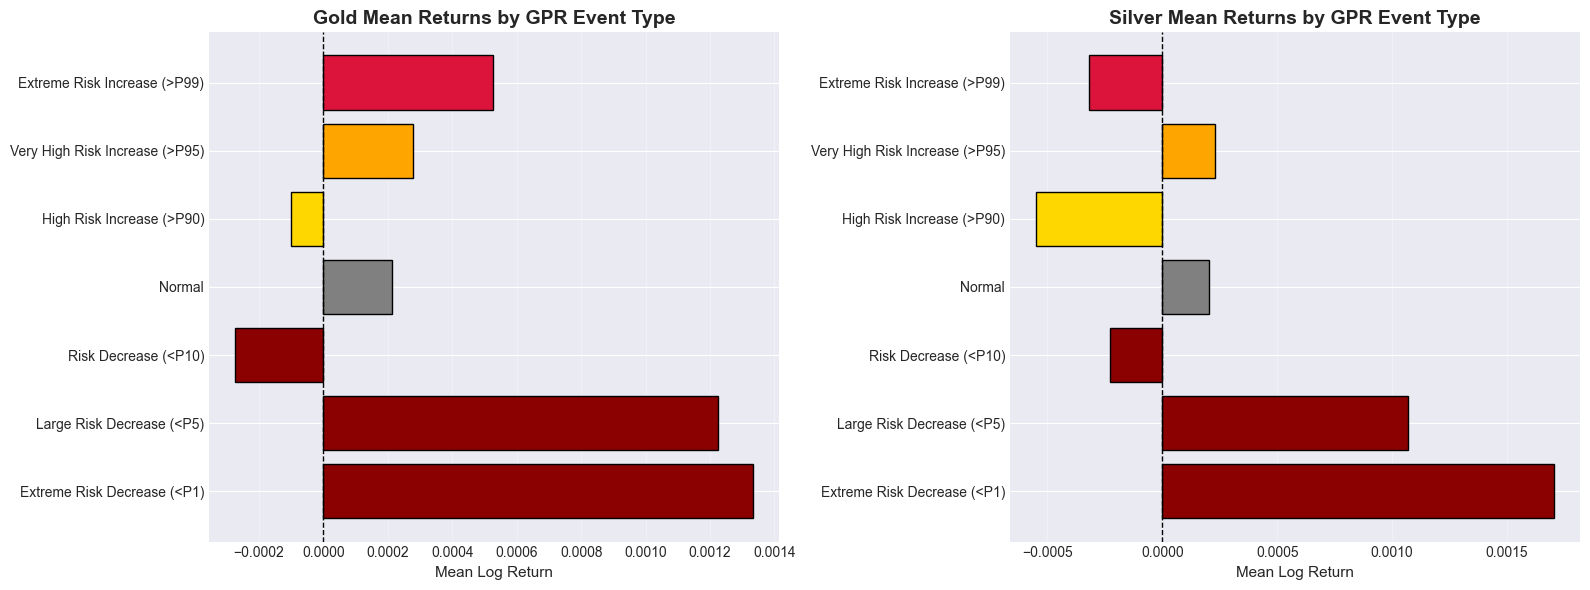

In [12]:
# Visualize mean returns by event type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gold
colors = ['darkred' if 'Decrease' in idx else ('crimson' if 'Extreme' in idx else ('orange' if 'Very High' in idx else ('gold' if 'High' in idx else 'gray'))) for idx in event_means.index]
axes[0].barh(event_means.index, event_means['GOLD_LOG_RETURN'], color=colors, edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Gold Mean Returns by GPR Event Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mean Log Return', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')

# Silver
axes[1].barh(event_means.index, event_means['SILVER_LOG_RETURN'], color=colors, edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Silver Mean Returns by GPR Event Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mean Log Return', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [13]:
# Statistical test: t-test comparing returns during extreme risk increases vs normal periods
normal_gold = df_complete[df_complete['GPR_EVENT'] == 'Normal']['GOLD_LOG_RETURN'].dropna()
extreme_gold = df_complete[df_complete['GPR_EVENT'] == 'Extreme Risk Increase (>P99)']['GOLD_LOG_RETURN'].dropna()

normal_silver = df_complete[df_complete['GPR_EVENT'] == 'Normal']['SILVER_LOG_RETURN'].dropna()
extreme_silver = df_complete[df_complete['GPR_EVENT'] == 'Extreme Risk Increase (>P99)']['SILVER_LOG_RETURN'].dropna()

print("="*80)
print("T-TEST: EXTREME GPR SHOCKS vs NORMAL PERIODS")
print("="*80)

if len(extreme_gold) > 1 and len(normal_gold) > 1:
    t_stat_gold, p_val_gold = stats.ttest_ind(extreme_gold, normal_gold)
    print(f"\nGold Returns:")
    print(f"  Normal periods mean: {normal_gold.mean():.6f}")
    print(f"  Extreme GPR shock mean: {extreme_gold.mean():.6f}")
    print(f"  Difference: {extreme_gold.mean() - normal_gold.mean():.6f}")
    print(f"  t-statistic: {t_stat_gold:.4f}")
    print(f"  p-value: {p_val_gold:.6f}")
    if p_val_gold < 0.05:
        print(f"  ✓ Significant difference (p < 0.05)")
    else:
        print(f"  ✗ No significant difference (p ≥ 0.05)")

if len(extreme_silver) > 1 and len(normal_silver) > 1:
    t_stat_silver, p_val_silver = stats.ttest_ind(extreme_silver, normal_silver)
    print(f"\nSilver Returns:")
    print(f"  Normal periods mean: {normal_silver.mean():.6f}")
    print(f"  Extreme GPR shock mean: {extreme_silver.mean():.6f}")
    print(f"  Difference: {extreme_silver.mean() - normal_silver.mean():.6f}")
    print(f"  t-statistic: {t_stat_silver:.4f}")
    print(f"  p-value: {p_val_silver:.6f}")
    if p_val_silver < 0.05:
        print(f"  ✓ Significant difference (p < 0.05)")
    else:
        print(f"  ✗ No significant difference (p ≥ 0.05)")

T-TEST: EXTREME GPR SHOCKS vs NORMAL PERIODS

Gold Returns:
  Normal periods mean: 0.000212
  Extreme GPR shock mean: 0.000525
  Difference: 0.000313
  t-statistic: 0.3271
  p-value: 0.743592
  ✗ No significant difference (p ≥ 0.05)

Silver Returns:
  Normal periods mean: 0.000203
  Extreme GPR shock mean: -0.000319
  Difference: -0.000522
  t-statistic: -0.3039
  p-value: 0.761185
  ✗ No significant difference (p ≥ 0.05)


## 7. Time Series Visualization: Shocks and Returns

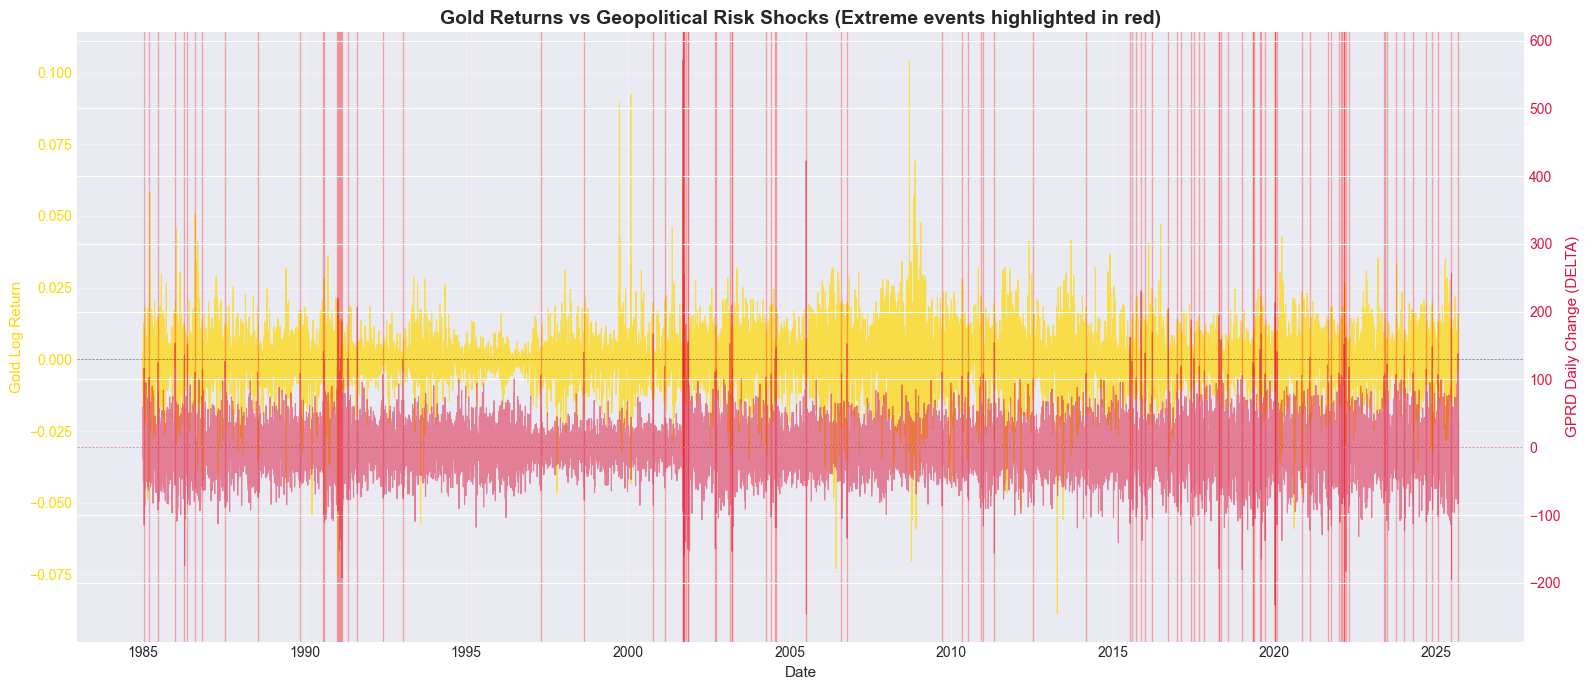

In [14]:
# Visualize relationship over time: GPRD_DELTA vs Gold Returns
fig, ax1 = plt.subplots(figsize=(16, 7))

# Gold returns on left y-axis
color = 'gold'
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Gold Log Return', color=color, fontsize=11)
ax1.plot(df_complete.index, df_complete['GOLD_LOG_RETURN'], color=color, linewidth=0.8, alpha=0.7, label='Gold Return')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.grid(True, alpha=0.3)

# GPRD_DELTA on right y-axis
ax2 = ax1.twinx()
color = 'crimson'
ax2.set_ylabel('GPRD Daily Change (DELTA)', color=color, fontsize=11)
ax2.plot(df_complete.index, df_complete['GPRD_DELTA'], color=color, linewidth=0.8, alpha=0.5, label='GPRD_DELTA')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=0, color='darkred', linestyle='--', linewidth=0.5, alpha=0.5)

# Highlight extreme events
extreme_dates = df_complete[df_complete['GPR_EVENT'] == 'Extreme Risk Increase (>P99)'].index
for date in extreme_dates:
    ax1.axvline(x=date, color='red', alpha=0.3, linewidth=1)

plt.title('Gold Returns vs Geopolitical Risk Shocks (Extreme events highlighted in red)', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

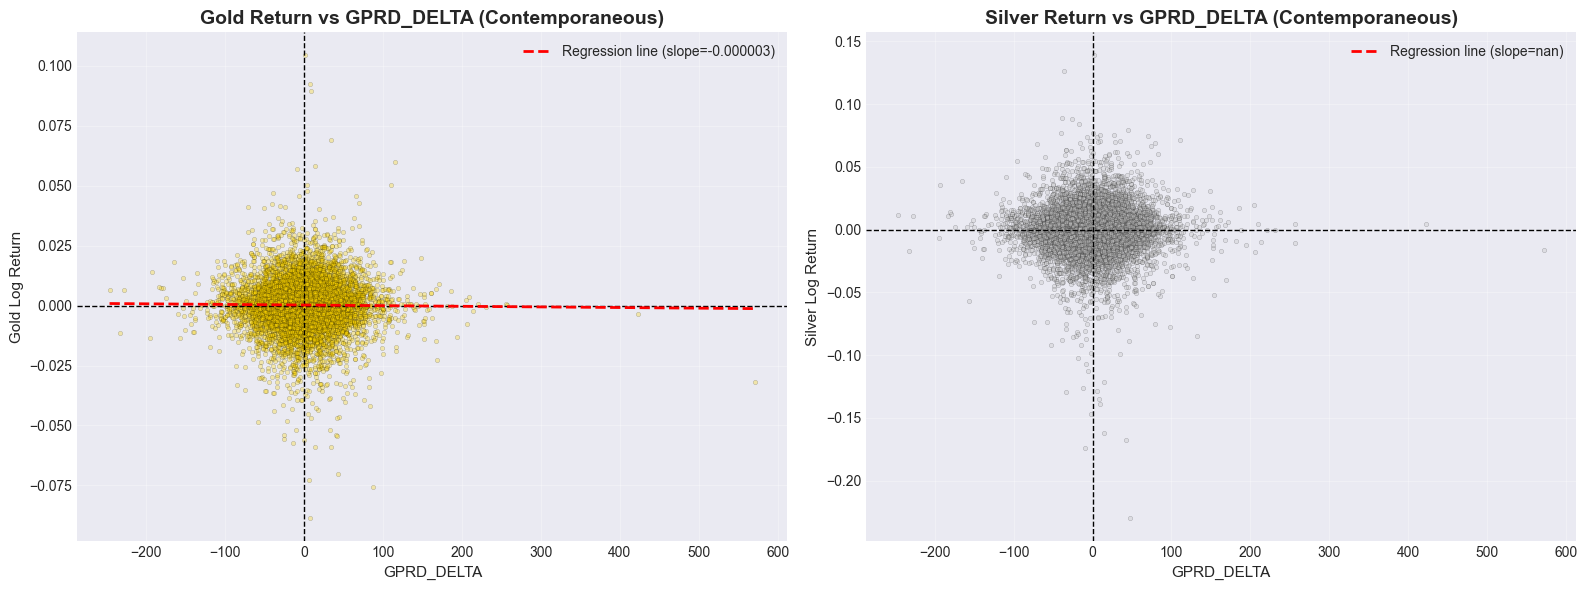

In [15]:
# Scatter plot: GPRD_DELTA vs Returns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gold
axes[0].scatter(df_complete['GPRD_DELTA'], df_complete['GOLD_LOG_RETURN'], 
                alpha=0.3, s=10, color='gold', edgecolors='black', linewidths=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)

# Add regression line - FIXED
x_gold = df_complete['GPRD_DELTA'].dropna()
y_gold = df_complete['GOLD_LOG_RETURN'].loc[x_gold.index]
z_gold = np.polyfit(x_gold, y_gold, 1)
p_gold = np.poly1d(z_gold)
x_plot = np.linspace(x_gold.min(), x_gold.max(), 100)
axes[0].plot(x_plot, p_gold(x_plot), "r--", linewidth=2, label=f'Regression line (slope={z_gold[0]:.6f})')

axes[0].set_title('Gold Return vs GPRD_DELTA (Contemporaneous)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('GPRD_DELTA', fontsize=11)
axes[0].set_ylabel('Gold Log Return', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Silver
axes[1].scatter(df_complete['GPRD_DELTA'], df_complete['SILVER_LOG_RETURN'], 
                alpha=0.3, s=10, color='silver', edgecolors='black', linewidths=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)

# Add regression line - FIXED
x_silver = df_complete['GPRD_DELTA'].dropna()
y_silver = df_complete['SILVER_LOG_RETURN'].loc[x_silver.index]
z_silver = np.polyfit(x_silver, y_silver, 1)
p_silver = np.poly1d(z_silver)
x_plot = np.linspace(x_silver.min(), x_silver.max(), 100)
axes[1].plot(x_plot, p_silver(x_plot), "r--", linewidth=2, label=f'Regression line (slope={z_silver[0]:.6f})')

axes[1].set_title('Silver Return vs GPRD_DELTA (Contemporaneous)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('GPRD_DELTA', fontsize=11)
axes[1].set_ylabel('Silver Log Return', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Directional Analysis: Risk Up = Price Up?

**Test**: When GPR increases (GPRD_DELTA > 0), do prices increase more often?

In [16]:
# Create directional categories
df_complete['GPR_DIRECTION'] = 'No Change'
df_complete.loc[df_complete['GPRD_DELTA'] > 0, 'GPR_DIRECTION'] = 'Risk Increase'
df_complete.loc[df_complete['GPRD_DELTA'] < 0, 'GPR_DIRECTION'] = 'Risk Decrease'

df_complete['GOLD_DIRECTION'] = 'No Change'
df_complete.loc[df_complete['GOLD_LOG_RETURN'] > 0, 'GOLD_DIRECTION'] = 'Price Up'
df_complete.loc[df_complete['GOLD_LOG_RETURN'] < 0, 'GOLD_DIRECTION'] = 'Price Down'

df_complete['SILVER_DIRECTION'] = 'No Change'
df_complete.loc[df_complete['SILVER_LOG_RETURN'] > 0, 'SILVER_DIRECTION'] = 'Price Up'
df_complete.loc[df_complete['SILVER_LOG_RETURN'] < 0, 'SILVER_DIRECTION'] = 'Price Down'

# Contingency table: GPR direction vs Gold direction
contingency_gold = pd.crosstab(df_complete['GPR_DIRECTION'], df_complete['GOLD_DIRECTION'], 
                               normalize='index') * 100
contingency_silver = pd.crosstab(df_complete['GPR_DIRECTION'], df_complete['SILVER_DIRECTION'], 
                                 normalize='index') * 100

print("="*70)
print("DIRECTIONAL ANALYSIS: % of Price Movements by GPR Direction")
print("="*70)
print("\nGold Price Direction (% of days):")
print(contingency_gold.round(2))
print("\nSilver Price Direction (% of days):")
print(contingency_silver.round(2))

DIRECTIONAL ANALYSIS: % of Price Movements by GPR Direction

Gold Price Direction (% of days):
GOLD_DIRECTION  No Change  Price Down  Price Up
GPR_DIRECTION                                  
No Change            0.00       75.00     25.00
Risk Decrease        1.16       48.77     50.07
Risk Increase        1.31       47.46     51.23

Silver Price Direction (% of days):
SILVER_DIRECTION  No Change  Price Down  Price Up
GPR_DIRECTION                                    
No Change              0.00       25.00     75.00
Risk Decrease          6.15       45.66     48.19
Risk Increase          6.17       43.99     49.85


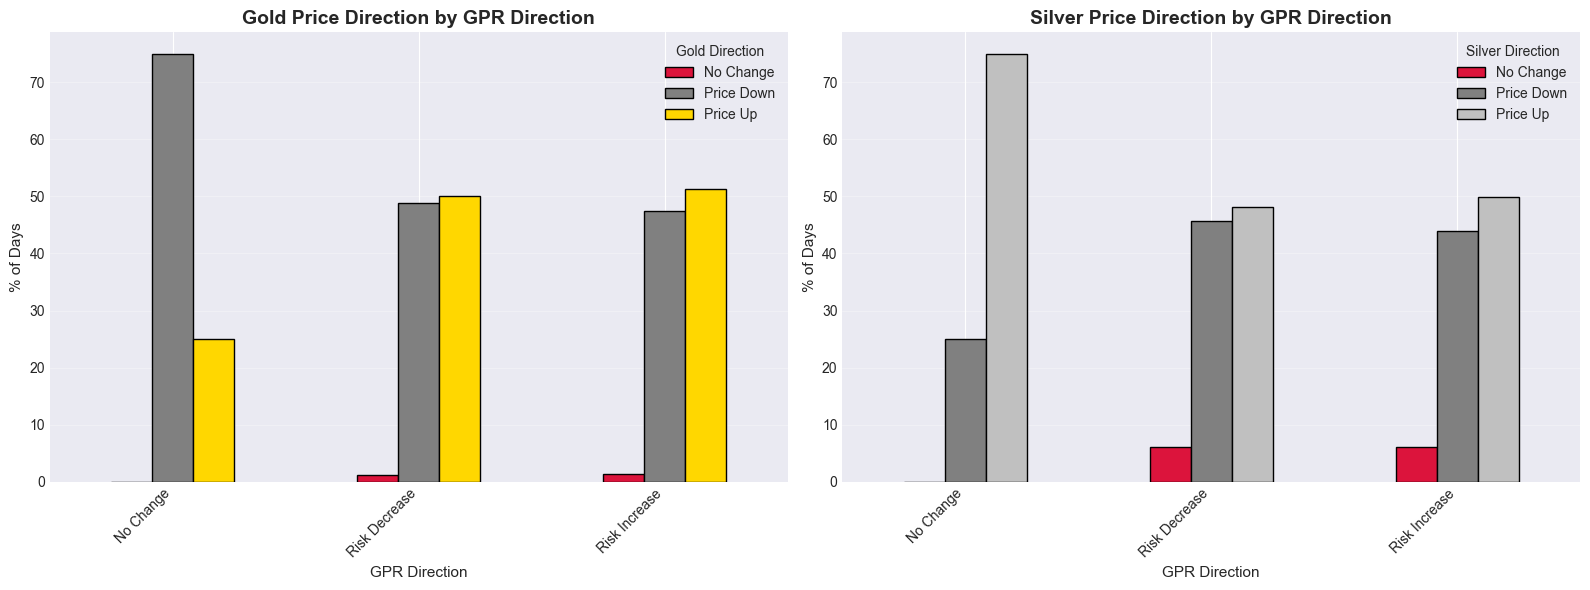

In [17]:
# Visualize contingency tables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gold
contingency_gold.plot(kind='bar', ax=axes[0], color=['crimson', 'gray', 'gold'], edgecolor='black')
axes[0].set_title('Gold Price Direction by GPR Direction', fontsize=14, fontweight='bold')
axes[0].set_xlabel('GPR Direction', fontsize=11)
axes[0].set_ylabel('% of Days', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title='Gold Direction')
axes[0].grid(True, alpha=0.3, axis='y')

# Silver
contingency_silver.plot(kind='bar', ax=axes[1], color=['crimson', 'gray', 'silver'], edgecolor='black')
axes[1].set_title('Silver Price Direction by GPR Direction', fontsize=14, fontweight='bold')
axes[1].set_xlabel('GPR Direction', fontsize=11)
axes[1].set_ylabel('% of Days', fontsize=11)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title='Silver Direction')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [18]:
# Chi-square test for independence
contingency_gold_counts = pd.crosstab(df_complete['GPR_DIRECTION'], df_complete['GOLD_DIRECTION'])
contingency_silver_counts = pd.crosstab(df_complete['GPR_DIRECTION'], df_complete['SILVER_DIRECTION'])

chi2_gold, p_gold, dof_gold, expected_gold = stats.chi2_contingency(contingency_gold_counts)
chi2_silver, p_silver, dof_silver, expected_silver = stats.chi2_contingency(contingency_silver_counts)

print("="*70)
print("CHI-SQUARE TEST: Independence of GPR Direction and Price Direction")
print("="*70)
print(f"\nGold:")
print(f"  Chi-square statistic: {chi2_gold:.4f}")
print(f"  p-value: {p_gold:.6f}")
print(f"  Degrees of freedom: {dof_gold}")
if p_gold < 0.05:
    print(f"  ✓ GPR direction and Gold price direction are DEPENDENT (p < 0.05)")
else:
    print(f"  ✗ GPR direction and Gold price direction are INDEPENDENT (p ≥ 0.05)")

print(f"\nSilver:")
print(f"  Chi-square statistic: {chi2_silver:.4f}")
print(f"  p-value: {p_silver:.6f}")
print(f"  Degrees of freedom: {dof_silver}")
if p_silver < 0.05:
    print(f"  ✓ GPR direction and Silver price direction are DEPENDENT (p < 0.05)")
else:
    print(f"  ✗ GPR direction and Silver price direction are INDEPENDENT (p ≥ 0.05)")

CHI-SQUARE TEST: Independence of GPR Direction and Price Direction

Gold:
  Chi-square statistic: 3.2909
  p-value: 0.510367
  Degrees of freedom: 4
  ✗ GPR direction and Gold price direction are INDEPENDENT (p ≥ 0.05)

Silver:
  Chi-square statistic: 4.2617
  p-value: 0.371744
  Degrees of freedom: 4
  ✗ GPR direction and Silver price direction are INDEPENDENT (p ≥ 0.05)


## 9. Quantile Regression Analysis

**Test**: Does the relationship vary across different quantiles of the return distribution?

MEAN RETURNS BY GPRD_DELTA QUANTILE (Deciles)
                     GOLD_LOG_RETURN  SILVER_LOG_RETURN  GPRD_DELTA
GPRD_DELTA_QUANTILE                                                
0                           0.000486           0.000485  -69.235404
1                           0.000512           0.000547  -37.298964
2                          -0.000216          -0.000502  -23.337353
3                           0.000049          -0.000140  -13.277821
4                           0.000206          -0.000133   -4.907379
5                           0.000137           0.000430    3.625195
6                           0.000518          -0.000084   12.928525
7                           0.000203           0.000630   23.035546
8                           0.000289           0.000875   36.688536
9                           0.000114          -0.000216   71.481406


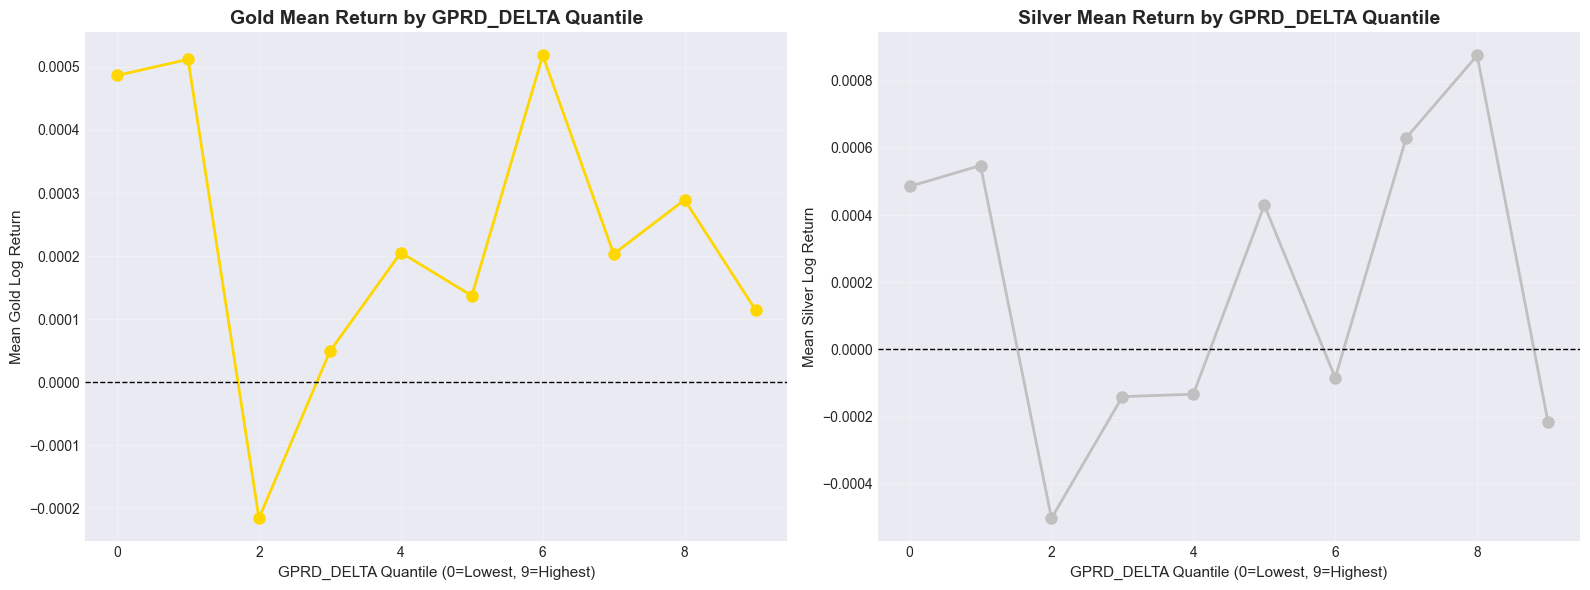

In [19]:
# Conditional mean returns by GPRD_DELTA quantiles
df_complete['GPRD_DELTA_QUANTILE'] = pd.qcut(df_complete['GPRD_DELTA'], q=10, labels=False, duplicates='drop')

quantile_analysis = df_complete.groupby('GPRD_DELTA_QUANTILE')[['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN', 'GPRD_DELTA']].mean()

print("="*70)
print("MEAN RETURNS BY GPRD_DELTA QUANTILE (Deciles)")
print("="*70)
print(quantile_analysis.round(6))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gold
axes[0].plot(quantile_analysis.index, quantile_analysis['GOLD_LOG_RETURN'], 
             marker='o', color='gold', linewidth=2, markersize=8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Gold Mean Return by GPRD_DELTA Quantile', fontsize=14, fontweight='bold')
axes[0].set_xlabel('GPRD_DELTA Quantile (0=Lowest, 9=Highest)', fontsize=11)
axes[0].set_ylabel('Mean Gold Log Return', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Silver
axes[1].plot(quantile_analysis.index, quantile_analysis['SILVER_LOG_RETURN'], 
             marker='o', color='silver', linewidth=2, markersize=8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Silver Mean Return by GPRD_DELTA Quantile', fontsize=14, fontweight='bold')
axes[1].set_xlabel('GPRD_DELTA Quantile (0=Lowest, 9=Highest)', fontsize=11)
axes[1].set_ylabel('Mean Silver Log Return', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Summary: Safe-Haven Hypothesis Validation

In [20]:
# Compile key findings
print("="*80)
print("SAFE-HAVEN HYPOTHESIS VALIDATION SUMMARY")
print("="*80)

# 1. Correlations
gold_gprd_corr = corr_matrix_contemp.loc['GOLD_LOG_RETURN', 'GPRD_DELTA']
silver_gprd_corr = corr_matrix_contemp.loc['SILVER_LOG_RETURN', 'GPRD_DELTA']
gold_gprd_lag_corr = corr_matrix_lagged.loc['GOLD_LOG_RETURN', 'GPRD_DELTA_LAG1']
silver_gprd_lag_corr = corr_matrix_lagged.loc['SILVER_LOG_RETURN', 'GPRD_DELTA_LAG1']

print(f"\n1. CORRELATION ANALYSIS:")
print(f"   Contemporaneous:")
print(f"     Gold-GPRD_DELTA:   {gold_gprd_corr:.6f}")
print(f"     Silver-GPRD_DELTA: {silver_gprd_corr:.6f}")
print(f"   Lagged (predictive):")
print(f"     Gold-GPRD_DELTA(t-1):   {gold_gprd_lag_corr:.6f}")
print(f"     Silver-GPRD_DELTA(t-1): {silver_gprd_lag_corr:.6f}")

# 2. Extreme events
if len(extreme_gold) > 0 and len(normal_gold) > 0:
    print(f"\n2. EXTREME EVENTS ANALYSIS (P99):")
    print(f"   Gold return during extreme GPR shocks:  {extreme_gold.mean():.6f}")
    print(f"   Gold return during normal periods:      {normal_gold.mean():.6f}")
    print(f"   Difference:                              {extreme_gold.mean() - normal_gold.mean():.6f}")
    
    print(f"\n   Silver return during extreme GPR shocks: {extreme_silver.mean():.6f}")
    print(f"   Silver return during normal periods:     {normal_silver.mean():.6f}")
    print(f"   Difference:                               {extreme_silver.mean() - normal_silver.mean():.6f}")

# 3. Directional analysis
gold_up_when_gpr_up = contingency_gold.loc['Risk Increase', 'Price Up']
gold_up_when_gpr_down = contingency_gold.loc['Risk Decrease', 'Price Up']
silver_up_when_gpr_up = contingency_silver.loc['Risk Increase', 'Price Up']
silver_up_when_gpr_down = contingency_silver.loc['Risk Decrease', 'Price Up']

print(f"\n3. DIRECTIONAL ANALYSIS:")
print(f"   Gold price increases when GPR increases:  {gold_up_when_gpr_up:.1f}%")
print(f"   Gold price increases when GPR decreases:  {gold_up_when_gpr_down:.1f}%")
print(f"   Silver price increases when GPR increases: {silver_up_when_gpr_up:.1f}%")
print(f"   Silver price increases when GPR decreases: {silver_up_when_gpr_down:.1f}%")

# 4. Overall conclusion
print(f"\n4. CONCLUSION:")
if gold_gprd_corr > 0:
    print(f"   ✓ Gold shows POSITIVE contemporaneous correlation with GPR shocks")
else:
    print(f"   ✗ Gold shows NEGATIVE contemporaneous correlation with GPR shocks")
    
if extreme_gold.mean() > normal_gold.mean():
    print(f"   ✓ Gold returns are HIGHER during extreme geopolitical events")
else:
    print(f"   ✗ Gold returns are LOWER during extreme geopolitical events")
    
if gold_up_when_gpr_up > 50:
    print(f"   ✓ Gold price increases MORE OFTEN when GPR increases (>{50}%)")
else:
    print(f"   ✗ Gold price does NOT increase more often when GPR increases (<50%)")

print(f"\n" + "="*80)
print(f"Overall Safe-Haven Hypothesis: ", end="")
safe_haven_score = 0
if gold_gprd_corr > 0: safe_haven_score += 1
if extreme_gold.mean() > normal_gold.mean(): safe_haven_score += 1
if gold_up_when_gpr_up > 50: safe_haven_score += 1

if safe_haven_score >= 2:
    print("SUPPORTED (majority of evidence confirms hypothesis)")
else:
    print("NOT SUPPORTED (majority of evidence rejects hypothesis)")
print("="*80)

SAFE-HAVEN HYPOTHESIS VALIDATION SUMMARY

1. CORRELATION ANALYSIS:
   Contemporaneous:
     Gold-GPRD_DELTA:   -0.010615
     Silver-GPRD_DELTA: -0.003426
   Lagged (predictive):
     Gold-GPRD_DELTA(t-1):   0.008646
     Silver-GPRD_DELTA(t-1): 0.008934

2. EXTREME EVENTS ANALYSIS (P99):
   Gold return during extreme GPR shocks:  0.000525
   Gold return during normal periods:      0.000212
   Difference:                              0.000313

   Silver return during extreme GPR shocks: -0.000319
   Silver return during normal periods:     0.000203
   Difference:                               -0.000522

3. DIRECTIONAL ANALYSIS:
   Gold price increases when GPR increases:  51.2%
   Gold price increases when GPR decreases:  50.1%
   Silver price increases when GPR increases: 49.8%
   Silver price increases when GPR decreases: 48.2%

4. CONCLUSION:
   ✗ Gold shows NEGATIVE contemporaneous correlation with GPR shocks
   ✓ Gold returns are HIGHER during extreme geopolitical events
   ✓ Gold

## 11. Export Results (Optional)

In [21]:
# Save processed data with GPR deltas for modeling
# df_complete.to_csv('../data/gold_silver_safehaven_analysis.csv')
# print("✓ Analysis data saved to 'data/gold_silver_safehaven_analysis.csv'")